*Wordpiece Model(WPM)* 은 우리가 접한 적이 있는 아이디어를 기반으로 만들어졌습니다. 두 단어 `preview`와 `predict`를 보면 접두어인 `pre`가 공통되고 있죠? `pre`가 들어간 단어는 주로 **"미리", "이전의"** 와 연계되는 의미를 가지고 있습니다. 컴퓨터도 두 단어를 따로 볼 게 아니라 `pre+view`와 `pre+dict`로 본다면 학습을 더 잘 할 수 있지 않을까요?

이처럼 한 단어를 여러 개의 Subword의 집합으로 보는 방법이 WPM입니다. WPM의 원리를 알기 전, 먼저 알아야 할 것이 바로 **Byte Pair Encoding(BPE)** 입니다.

## Byte Pair Encoding(BPE)

---

BPE 알고리즘이 고안된 것은 1994년입니다. 그때는 자연어 처리에 적용하기 위해서가 아니라 데이터 압축을 위해서 생겨났었죠. 데이터에서 **가장 많이 등장하는 바이트 쌍(Byte Pair)** 을 새로운 단어로 치환하여 압축하는 작업을 반복하는 방식으로 동작합니다. 예시는 아래와 같습니다.

```
aaabdaaabac # 가장 많이 등장한 바이트 쌍 "aa"를 "Z"로 치환합니다.
→ 
ZabdZabac   # "aa" 총 두 개가 치환되어 4바이트를 2바이트로 압축하였습니다.
Z=aa        # 그다음 많이 등장한 바이트 쌍 "ab"를 "Y"로 치환합니다.
→ 
ZYdZYac     # "ab" 총 두 개가 치환되어 4바이트를 2바이트로 압축하였습니다.
Z=aa        # 여기서 작업을 멈추어도 되지만, 치환된 바이트에 대해서도 진행한다면
Y=ab        # 가장 많이 등장한 바이트 쌍 "ZY"를 "X"로 치환합니다.
→ 
XdXac
Z=aa
Y=ab
X=ZY       # 압축이 완료되었습니다!
```

아주 직관적인 알고리즘이죠? 이를 토큰화에 적용하자고 제안한 것은 2015년이었습니다. 모든 단어를 문자(바이트)들의 집합으로 취급하여 자주 등장하는 문자 쌍을 합치면, 접두어나 접미어의  의미를 캐치할 수 있고, 처음 등장하는 단어는 문자(알파벳)들의 조합으로 나타내어 **OOV 문제를 완전히 해결**할 수 있다는 것이죠!

비교적 최근의 기술을 소개해드리는 만큼 논문을 함께 첨부합니다.

- [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/pdf/1508.07909.pdf)

위 논문은 Python 소스 코드를 함께 제공해 주어 간편하게 실습을 해 볼 수 있습니다. 논문에서 제공해 주는 예제로 동작 방식을 자세히 들여다보죠!

## n-grams
- 유니그램 (1)
- 바이그램 (2)
- 트라이그램 (3)

나는 학교에 가서 공부를 합니다.

In [2]:
def n_grams(text, n):
    return [text[i:i+n] for i in range(len(text)-n+1)]

cleaned = ['mary', ',', "n't", 'slap', 'green', 'witch', '.']
print(n_grams(cleaned, 1))

[['mary'], [','], ["n't"], ['slap'], ['green'], ['witch'], ['.']]


## BPE Algorithm

In [32]:
import re, collections

In [33]:
num_merges = 10 # BPE를 몇 회 수행할 것지 정함.

```
# BPE corpus
corpus = """
low lower newest widest
low lower newest widest
low       newest widest
low       newest
low       newest
          newest
"""
```

In [34]:
dictionary = {'l o w </w>' : 5,
              'l o w e r </w>' : 2,
              'n e w e s t </w>' : 6,
              'w i d e s t </w>' :3
}

In [35]:
def get_stats(dictionary):

    """
    단어 사전을 불러와
    단어는 공백 단위로 쪼개어 문자 list를 만들고
    빈도수와 쌍을 이루게 합니다. (symbols)
    """
    
  # 유니그램의 pair들의 빈도수를 카운트
    pairs = collections.defaultdict(int)
    for word, freq in dictionary.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    print('현재 pair들의 빈도수 :', dict(pairs))
    return pairs

In [36]:
def merge_dictionary(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

In [37]:
bpe_codes = {}
bpe_codes_reverse = {}
for i in range(num_merges):
    print(">> Step {0}".format(i+1))
    pairs = get_stats(dictionary)
    best = max(pairs, key=pairs.get)
    dictionary = merge_dictionary(best, dictionary)

    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best

    print("new merge: {}".format(best))
    print("dictionary: {}".format(dictionary))

>> Step 1
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 8, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('e', 's'): 9, ('s', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'e'): 3}
new merge: ('e', 's')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}
>> Step 2
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'es'): 6, ('es', 't'): 9, ('t', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'es'): 3}
new merge: ('es', 't')
dictionary: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}
>> Step 3
현재 pair들의 빈도수 : {('l', 'o'): 7, ('o', 'w'): 7, ('w', '</w>'): 5, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('n', 'e'): 6, ('e', 'w'): 6, ('w', 'est'): 6, ('est', '</w>'): 9, ('w', 'i'): 3, ('i', 'd'): 3, ('d', 'est'): 3}
new merge: ('est', '</w>')
dictiona

In [38]:
print(bpe_codes)

{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9}


## OOV 대처하기

만일 `lowest`라는 처음 보는 단어가 등장하더라도, 위 알고리즘을 따르면 어느 정도 의미가 파악된 `low`와 `est`의 결합으로 표현할 수 있습니다. 또 BPE의 놀라운 점은 아무리 큰 데이터도 원하는 크기로 OOV 문제없이 사전을 정의할 수 있다는 것입니다. 극단적으로 생각했을 때 알파벳 26개와 특수문자, 문장부호를 아무리 추가해도 100개 이내로 사전을 정의할 수 있죠.(물론 그러면 안 됩니다!!)

Embedding 레이어는  **단어의 개수 x Embedding 차원 수** 의 Weight를 생성하기 때문에 단어의 개수가 줄어드는 것은 곧 메모리의 절약으로 이어집니다. 많은 데이터가 곧 정확도로 이어지기 때문에 이런 기여는 굉장히 의미가 있습니다!

하지만 아직도! 완벽하다고는 할 수 없습니다. 만약 수많은 데이터를 사용해 만든 BPE 사전으로 모델을 학습시키고 문장을 생성하게 했다고 합시다. 그게 `[i, am, a, b, o, y, a, n, d, you, are, a, gir, l]`이라면, 어떤 기준으로 이들을 결합해서 문장을 복원하죠? 몽땅 한꺼번에 합쳤다간 끔찍한 일이 벌어질 것만 같습니다... 

In [39]:
def get_pairs(word):
  pairs = set()
  prev_char = word[0]
  for char in word[1:]:
    pairs.add((prev_char, char))
    prev_char = char
  return pairs

In [40]:
orig = 'hi'
word = tuple(orig) + ('</w>',)
print(word)

('h', 'i', '</w>')


In [41]:
def encode(orig):
  word = tuple(orig) + ('</w>',)
  print("__word split into characters:__ <tt>{}<tt>".format(word))

  pairs = get_pairs(word)

  if not pairs:
    return orig
  
  iteration = 0
  while True:
    iteration += 1
    print("__Iteration {}:__".format(iteration))

    print("Bigram in the word: {}".format(pairs))
    bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
    print("candidate for merging: {}".format(bigram))
    if bigram not in bpe_codes:
      print("__Candidate not in BPE merges, algorithm stops.__")
      break
    first, second = bigram
    new_word = []
    i = 0
    while i < len(word):
      try:
        j = word.index(first, i)
        new_word.extend(word[i:j])
        i = j
      except:
        new_word.extend(word[i:])
        break

      if word[i] == first and i < len(word)-1 and word[i+1] == second:
        new_word.append(first+second)
        i += 2
      else:
        new_word.append(word[i])
        i += 1
    new_word = tuple(new_word)
    word = new_word
    print("word after merging : {}".format(word))
    if len(word) == 1:
      break
    else:
      pairs = get_pairs(word)
  
  # 특별토큰인 </w>는 출력하지 않는다.
  if word[-1] == '</w>':
    word = word[:-1]
  elif word[-1].endswith('</w>'):
    word = word[:-1] + (word[-1].replace('</w>', ''), )
  return word

단어 'loki'가 들어오면 BPE 알고리즘 해당 단어를 어떻게 분리할까요?


In [42]:
encode("loki")

__word split into characters:__ <tt>('l', 'o', 'k', 'i', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('o', 'k'), ('l', 'o'), ('i', '</w>'), ('k', 'i')}
candidate for merging: ('l', 'o')
word after merging : ('lo', 'k', 'i', '</w>')
__Iteration 2:__
Bigram in the word: {('i', '</w>'), ('lo', 'k'), ('k', 'i')}
candidate for merging: ('i', '</w>')
__Candidate not in BPE merges, algorithm stops.__


('lo', 'k', 'i')

현재 서브워드 단어집합에는 'lo'가 존재하므로, 'lo'는 유지하고 'k'와 'i'는 분리시킵니다. 단어 'lowest'에 대해서도 수행해봅시다.

In [43]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('t', '</w>'), ('w', 'e'), ('l', 'o'), ('e', 's'), ('s', 't'), ('o', 'w')}
candidate for merging: ('e', 's')
word after merging : ('l', 'o', 'w', 'es', 't', '</w>')
__Iteration 2:__
Bigram in the word: {('t', '</w>'), ('l', 'o'), ('w', 'es'), ('es', 't'), ('o', 'w')}
candidate for merging: ('es', 't')
word after merging : ('l', 'o', 'w', 'est', '</w>')
__Iteration 3:__
Bigram in the word: {('l', 'o'), ('est', '</w>'), ('w', 'est'), ('o', 'w')}
candidate for merging: ('est', '</w>')
word after merging : ('l', 'o', 'w', 'est</w>')
__Iteration 4:__
Bigram in the word: {('l', 'o'), ('o', 'w'), ('w', 'est</w>')}
candidate for merging: ('l', 'o')
word after merging : ('lo', 'w', 'est</w>')
__Iteration 5:__
Bigram in the word: {('w', 'est</w>'), ('lo', 'w')}
candidate for merging: ('lo', 'w')
word after merging : ('low', 'est</w>')
__Iteration 6:__
Bigram in the word: {('low', 

('low', 'est')

현재 서브워드 단어집합에 'low'와 'est'가 존재하므로, 'low'와 'est'를 분리시킵니다. 단어 'lowing'에 대해서도 수행해봅시다.

In [44]:
encode("lowing")

__word split into characters:__ <tt>('l', 'o', 'w', 'i', 'n', 'g', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('i', 'n'), ('l', 'o'), ('w', 'i'), ('g', '</w>'), ('o', 'w'), ('n', 'g')}
candidate for merging: ('l', 'o')
word after merging : ('lo', 'w', 'i', 'n', 'g', '</w>')
__Iteration 2:__
Bigram in the word: {('i', 'n'), ('w', 'i'), ('g', '</w>'), ('lo', 'w'), ('n', 'g')}
candidate for merging: ('lo', 'w')
word after merging : ('low', 'i', 'n', 'g', '</w>')
__Iteration 3:__
Bigram in the word: {('n', 'g'), ('g', '</w>'), ('i', 'n'), ('low', 'i')}
candidate for merging: ('n', 'g')
__Candidate not in BPE merges, algorithm stops.__


('low', 'i', 'n', 'g')

현재 서브워드 단어집합에 'low'가 존재하지만, 'i', 'n', 'g'의 바이그램 조합으로 이루어진 서브워드는 존재하지 않으므로 'i', 'n', 'g'로 전부 분리합니다. 훈련된 데이터 중에서 어떤 서브워드도 존재하지 않는 'highing'은 어떨까요?

In [45]:
encode("highing")

__word split into characters:__ <tt>('h', 'i', 'g', 'h', 'i', 'n', 'g', '</w>')<tt>
__Iteration 1:__
Bigram in the word: {('i', 'n'), ('h', 'i'), ('g', '</w>'), ('i', 'g'), ('n', 'g'), ('g', 'h')}
candidate for merging: ('i', 'n')
__Candidate not in BPE merges, algorithm stops.__


('h', 'i', 'g', 'h', 'i', 'n', 'g')

## Wordpiece Model(WPM)

---

이에 구글에서 BPE를 변형해 제안한 알고리즘이 바로 WPM입니다. WPM은 BPE에 대해 **두 가지 차별성**을 가집니다.

1. 공백 복원을 위해 단어의 시작 부분에 언더바 _ 를 추가합니다.
2. 빈도수 기반이 아닌 가능도(Likelihood)를 증가시키는 방향으로 문자 쌍을 합칩니다.

첫 번째 문항은 아주 쉬운 내용으로, 앞서 사용한 예문을 빌리면 `[_i, _am, _a, _b, o, y, _a, n, d, _you, _are, _a, _gir, l]`로 토큰화를 한다는 것입니다. 이렇게 하면 문장을 복원하는 과정이 **1) 모든 토큰을 합친 후, 2) 언더바 _를 공백으로 치환**으로 마무리되어 간편하죠.

두 번째 문항은 다소 난해하게 다가올 수도 있습니다. 직관적인 이해를 얻고 넘어가는 것을 목표로 하죠. 본 내용은 아래 논문 3절과 4절에 자세하게 나와 있습니다.
   
- [JAPANESE AND KOREAN VOICE SEARCH](https://static.googleusercontent.com/media/research.google.com/ko//pubs/archive/37842.pdf)

(여기서 잠깐)
구글에서 이 기법을 한국어, 일본어 텍스트 처리를 위해 고려했다는 사실이 흥미롭지 않나요? 이 점은 2가지를 시사합니다. 
- 조사, 어미 등의 활용이 많고 복잡한 한국어 같은 모델의 토크나이저로 WPM이 좋은 대안이 될 수 있다.
- WPM은 어떤 언어든 무관하게 적용 가능한 language-neutral하고 general한 기법이다. 한국어 형태소 분석기처럼 한국어에만 적용 가능한 기법보다 훨씬 활용도가 크다.  

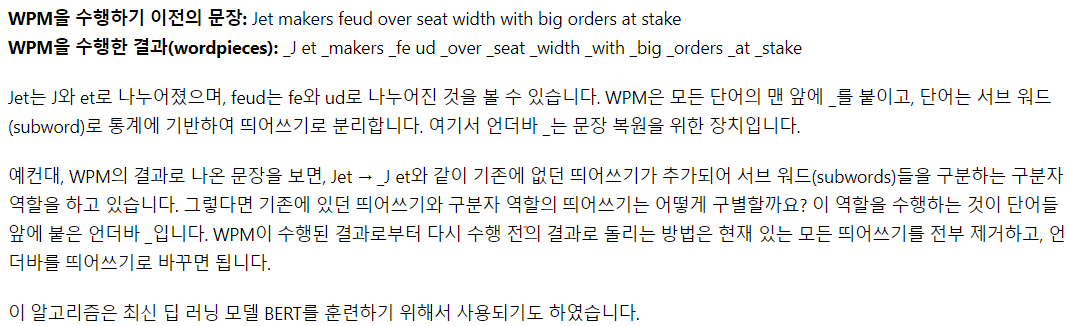

토큰화의 끝판왕으로 보이는 이 WPM은 아쉽게도 공개되어 있지는 않습니다. 대신에 구글의 *SentencePiece* 라이브러리를 통해 고성능의 BPE를 사용할 수 있습니다! *SentencePiece*에는 전처리 과정도 포함되어 있어서, 데이터를 따로 정제할 필요가 없어 간편하기까지 합니다. 따라서 아래 깃허브 페이지에 방문해 사용법을 간단히 눈으로 봐두도록 하죠!  아마 다음 프로젝트 노드에서는 *SentencePiece* 라이브러리를 적극적으로 활용하는 실습을 진행하게 될 것입니다. 

- [google/sentencepiece](https://github.com/google/sentencepiece)

이제 우리는 어떤 언어에도 OOV 발생 우려 없이 안정적으로 활용할 수 있는 멋진 토크나이징 기술을 확보했습니다. 이제는 컴퓨터가 단어사전을 안심하고 활용할 수 있겠군요!

하지만 아직 우리는 제대로 된 단어의 분산 표현을 얻는 법을 제대로 다루지는 않았습니다. 이쯤에서 이런 고민이 생기게 됩니다. 한국어라면 `자동차`를 `_자동 / 차` 로 분리되는데... 속성이 아무리 추상적이래도 보기에 `차`가 마시는 차인지, 달리는 차인지 도통 알 수가 없죠? 게다가 설령 토큰화가 완벽하다고 해도, `남자`가 `[-1, 0]`인지 `[1, 0]`인지는 컴퓨터 입장에서는 알 도리가 없습니다.

Embedding 레이어는 선언 즉시 랜덤한 실수로 Weight 값을 채우고, 학습을 진행하며 적당히 튜닝해가는 방식으로 속성을 맞춰가지만 이는 뭔가 찜찜합니다. 토큰들이 멋지게 의미를 갖게 하는 방법은 없을까요?

## IMDB리뷰 tensorflow의 subwordTextEncoder로 토큰화

In [46]:
import tensorflow_datasets as tfds
import urllib.request
import pandas as pd

In [47]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7fea95381c90>)

In [48]:
train_df = pd.read_csv('IMDb_Reviews.csv')

In [ ]:
train_df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [49]:
# train_df에서 'review'컬럼만 출력하시오.
train_df['review']

0        My family and I normally do not watch local mo...
1        Believe it or not, this was at one time the wo...
2        After some internet surfing, I found the "Home...
3        One of the most unheralded great works of anim...
4        It was the Sixties, and anyone with long hair ...
                               ...                        
49995    the people who came up with this are SICK AND ...
49996    The script is so so laughable... this in turn,...
49997    "So there's this bride, you see, and she gets ...
49998    Your mind will not be satisfied by this nobud...
49999    The chaser's war on everything is a weekly sho...
Name: review, Length: 50000, dtype: object

In [50]:
# train_df에서 'sentiment'컬럼만 출력하시오.
train_df['sentiment']

0        1
1        0
2        0
3        1
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    1
Name: sentiment, Length: 50000, dtype: int64

In [51]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_df['review'], target_vocab_size=2**13)

In [52]:
# tokenizer의 subword를 100까지 출력하세요.
print(tokenizer.subwords[:100])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 't_', 'as_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', 'are_', ' (', 'have_', 'his_', 'film_', 'not_', 'be_', 'you_', 'ing_', ' "', 'ed_', 'it', 'd_', 'an_', 'at_', 'by_', 'he_', 'one_', 'who_', 'from_', 'y_', 'or_', 'e_', 'like_', 'all_', '" ', 'they_', 'so_', 'just_', 'has_', ') ', 'about_', 'her_', 'out_', 'This_', 'some_', 'movie', 'ly_', 'film', 'very_', 'more_', 'It_', 'what_', 'would_', 'when_', 'if_', 'good_', 'up_', 'which_', 'their_', 'only_', 'even_', 'my_', 'really_', 'had_', 'can_', 'no_', 'were_', 'see_', '? ', 'she_', 'than_', '! ', 'there_', 'been_', 'get_', 'into_', 'will_', ' - ', 'much_', 'n_', 'because_', 'ing']


In [53]:
# train_df의 'review'컬럼에서 20번째 문장을 출력하시오.
print(train_df['review'][20])

Pretty bad PRC cheapie which I rarely bother to watch over again, and it's no wonder -- it's slow and creaky and dull as a butter knife. Mad doctor George Zucco is at it again, turning a dimwitted farmhand in overalls (Glenn Strange) into a wolf-man. Unfortunately, the makeup is virtually non-existent, consisting only of a beard and dimestore fangs for the most part. If it were not for Zucco and Strange's presence, along with the cute Anne Nagel, this would be completely unwatchable. Strange, who would go on to play Frankenstein's monster for Unuiversal in two years, does a Lenny impression from "Of Mice and Men", it seems.<br /><br />*1/2 (of Four)


In [58]:
# tokenizer.encode를 활용하여 train_df의 20번째 문장을 텍스트 -> 숫자로 바꾸시오.
print("토큰화된 샘플 질문: {}".format(tokenizer.encode(train_df['review'][20])))

토큰화된 샘플 질문: [1590, 4162, 132, 7107, 1892, 2983, 578, 76, 12, 4632, 3422, 7, 160, 175, 372, 2, 5, 39, 8051, 8, 84, 2652, 497, 39, 8051, 8, 1374, 5, 3461, 2012, 48, 5, 2263, 21, 4, 2992, 127, 4729, 711, 3, 1391, 8044, 3557, 1277, 8102, 2154, 5681, 9, 42, 15, 372, 2, 3773, 4, 3502, 2308, 467, 4890, 1503, 11, 3347, 1419, 8127, 29, 5539, 98, 6099, 58, 94, 4, 1388, 4230, 8057, 213, 3, 1966, 2, 1, 6700, 8044, 9, 7069, 716, 8057, 6600, 2, 4102, 36, 78, 6, 4, 1865, 40, 5, 3502, 1043, 1645, 8044, 1000, 1813, 23, 1, 105, 1128, 3, 156, 15, 85, 33, 23, 8102, 2154, 5681, 5, 6099, 8051, 8, 7271, 1055, 2, 534, 22, 1, 3046, 5214, 810, 634, 8120, 2, 14, 71, 34, 436, 3311, 5447, 783, 3, 6099, 2, 46, 71, 193, 25, 7, 428, 2274, 2260, 6487, 8051, 8, 2149, 23, 1138, 4117, 6023, 163, 11, 148, 735, 2, 164, 4, 5277, 921, 3395, 1262, 37, 639, 1349, 349, 5, 2460, 328, 15, 5349, 8127, 24, 10, 16, 10, 17, 8054, 8061, 8059, 8062, 29, 6, 6607, 8126, 8053]


### 1) 샘플문장으로 인코딩 디코딩 해보기~!

In [55]:
# 리뷰데이터가 아닌 샘플 문장으로 인코딩하고 디코딩해보자!!
sample_string = "It's mind-blowing to me that this film was even made."

# 인코딩해서 저장 Hint: 변수명.encode
tokenized_string = tokenizer.encode(sample_string) # 텍스트 -> 숫자
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# 디코딩해서 저장 Hint: 변수명.decode
original_string = tokenizer.decode(tokenized_string) # 숫자 -> 텍스트
print('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 79, 681, 8058]
기존 문장: It's mind-blowing to me that this film was even made.


In [56]:
# Hint 변수명.vocab_size
print('단어 집합의 크기(Vocab size) :', tokenizer.vocab_size)

단어 집합의 크기(Vocab size) : 8268


In [60]:
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

137 ----> It
8051 ----> '
8 ----> s 
910 ----> mind
8057 ----> -
2169 ----> blow
36 ----> ing 
7 ----> to 
103 ----> me 
13 ----> that 
14 ----> this 
32 ----> film 
18 ----> was 
79 ----> even 
681 ----> made
8058 ----> .


### 2) 샘플문장으로 인코딩 디코딩 해보기~!

In [61]:
# 1번 샘플문장에서 even뒤에 xyz가 추가되었을 때, 결과가 어떻게 나올까?
sample_string = "It's mind-blowing to me that this film was evenxyz made."

# 인코딩해서 저장 
tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# 디코딩해서 저장
original_string = tokenizer.decode(tokenized_string)
print('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [137, 8051, 8, 910, 8057, 2169, 36, 7, 103, 13, 14, 32, 18, 7974, 8132, 8133, 997, 681, 8058]
기존 문장: It's mind-blowing to me that this film was evenxyz made.


In [63]:
# 새로운 단어 xyz에 대한 결과를 확인해보자!

for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

137 ----> It
8051 ----> '
8 ----> s 
910 ----> mind
8057 ----> -
2169 ----> blow
36 ----> ing 
7 ----> to 
103 ----> me 
13 ----> that 
14 ----> this 
32 ----> film 
18 ----> was 
7974 ----> even
8132 ----> x
8133 ----> y
997 ----> z 
681 ----> made
8058 ----> .


## 네이버 영화 리뷰로 서브워드토크나이저

In [64]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fea908673d0>)

In [65]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [66]:
# train_data 상위 5개를 출력
train_data[:5] # train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [67]:
print(train_data.isnull().values.any())

True


In [68]:
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64


In [69]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [71]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_data['document'], target_vocab_size = 2**13)

In [72]:
# 토크나이저의 subwords를 100개까지 출력
print(tokenizer.subwords[:100])

['. ', '..', '영화', '이_', '...', '의_', '는_', '도_', '다', ', ', '을_', '고_', '은_', '가_', '에_', '.. ', '한_', '너무_', '정말_', '를_', '고', '게_', '영화_', '지', '... ', '진짜_', '이', '다_', '요', '만_', '? ', '과_', '나', '가', '서_', '지_', '로_', '으로_', '아', '어', '....', '음', '한', '수_', '와_', '도', '네', '그냥_', '나_', '더_', '왜_', '이런_', '면_', '기', '하고_', '보고_', '하는_', '서', '좀_', '리', '자', '스', '안', '! ', '에서_', '영화를_', '미', 'ㅋㅋ', '네요', '시', '주', '라', '는', '오', '없는_', '에', '해', '사', '!!', '영화는_', '마', '잘_', '수', '영화가_', '만', '본_', '로', '그_', '지만_', '대', '은', '비', '의', '일', '개', '있는_', '없다', '함', '구', '하']


In [73]:
# 20번째 문장 인코딩
print('Tokenized sample question: {}'.format(tokenizer.encode(train_data['document'][20])))

Tokenized sample question: [669, 4700, 17, 1749, 8, 96, 131, 1, 48, 2239, 4, 7466, 32, 1274, 2655, 7, 80, 749, 1254]


In [76]:
sample_string = train_data['document'][21]

# encode
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

assert original_string == sample_string

정수 인코딩 후의 문장 [570, 892, 36, 584, 159, 7091, 201]
기존 문장: 보면서 웃지 않는 건 불가능하다


In [78]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

570 ----> 보면서 
892 ----> 웃
36 ----> 지 
584 ----> 않는 
159 ----> 건 
7091 ----> 불가능
201 ----> 하다


In [79]:
sample_string = '이 영화 굉장히 재밌다 킄핫핫ㅎ'
# encode
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

assert original_string == sample_string

정수 인코딩 후의 문장 [4, 23, 1364, 2157, 8235, 8128, 8130, 8235, 8147, 8169, 8235, 8147, 8169, 393]
기존 문장: 이 영화 굉장히 재밌다 킄핫핫ㅎ


In [80]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

4 ----> 이 
23 ----> 영화 
1364 ----> 굉장히 
2157 ----> 재밌다 
8235 ----> �
8128 ----> �
8130 ----> �
8235 ----> �
8147 ----> �
8169 ----> �
8235 ----> �
8147 ----> �
8169 ----> �
393 ----> ㅎ


## IMDB리뷰 sentencePiece로 토큰화

In [81]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 33.8 MB/s 


In [82]:
import sentencepiece as spm
import pandas as pd
import urllib.request
import csv

In [83]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7fea90b77d50>)

In [84]:
train_df = pd.read_csv('IMDb_Reviews.csv')

In [85]:
train_df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [86]:
print('리뷰 개수 : ', len(train_df))

리뷰 개수 :  50000


In [87]:
with open('imdb_review.txt', 'w', encoding='utf8') as f:
  f.write('\n'.join(train_df['review']))

sentencepiece의 자세한 실행 옵션 : https://github.com/google/sentencepiece

```
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰
```
```
spm.SentencePieceTrainer.Train('--input=imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')
```

In [88]:
corpus = "imdb_review.txt" #입력 corpus
prefix = "imdb" # 저장할 단어장 이름
vocab_size = 5000
spm.SentencePieceTrainer.Train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size}" +
    " --model_type=bpe" +
    " --max_sentence_length=9999") # 문장 최대 길이

- input : 학습시킬 파일
- model_prefix : 만들어질 모델 이름
- vocab_size : 단어집합크기
- model_type : 사용할 모델 (unigram(default), bpe, char, word)
- pad_id, pad_piece : pad token id, 값
- unk_id, unk_piece : unknown token id, 값
- bos_id, bos_piece : begin of sentence token id,값
- eos_id, eos_piece : end of sequence token id, 값
- user_defined_symbols : 사용자 정의 토큰

In [89]:
vocab_list = pd.read_csv('imdb.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

,0,1
2997,▁tort,-2994
1498,▁brilliant,-1495
471,▁being,-468
2511,▁public,-2508
4650,▁theatre,-4647
3223,▁exception,-3220
4581,John,-4578
3664,aint,-3661
4260,▁brutal,-4257
4589,▁hadn,-4586


In [ ]:
len(vocab_list)

In [90]:
sp = spm.SentencePieceProcessor()
vocab_file = "imdb.model"
sp.load(vocab_file)

True

In [91]:
lines = [
         "I didn't at all think of it this way.",
         "I have waited a long time for someone to film"
]
for line in lines:
  print(line)
  print(sp.encode_as_pieces(line)) # 문장을 입력하면 서브워드 시퀀스로 변환
  print(sp.encode_as_ids(line)) # 문장을 입력하면 정수 시퀀스로 변환
  print()

I didn't at all think of it this way.
['▁I', '▁didn', "'", 't', '▁at', '▁all', '▁think', '▁of', '▁it', '▁this', '▁way', '.']
[41, 623, 4950, 4926, 138, 169, 378, 30, 58, 73, 413, 4945]

I have waited a long time for someone to film
['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[41, 141, 1364, 1120, 4, 666, 285, 92, 1078, 33, 91]



In [92]:
sp.GetPieceSize() #단어집합의 크기

5000

In [93]:
sp.IdToPiece(120) #정수로부터 매핑되는 서브워드 변환

'▁not'

In [94]:
# 위에서 출력된 결과를 sp.PieceTold 안으로 입력하기
sp.PieceToId('▁not') # 서브워드로부터 매핑되는 정수로 변환

120

In [95]:
# 위에서 출력된 정수 시퀀스를 sp.DecodeIds의 정수 시퀀스에 입력하기
sp.DecodeIds([41, 141, 1364, 1120, 4, 666, 285, 92, 1078, 33, 91])

'I have waited a long time for someone to film'

In [96]:
# 서브워드 시퀀스로부터 문장으로 변환
sp.DecodePieces(['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film'])

'I have waited a long time for someone to film'

In [97]:
print(sp.encode('I have waited a long time for someone to film', out_type=str)) # subword시퀀스
print(sp.encode('I have waited a long time for someone to film', out_type=int)) # 정수 시퀀스

['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[41, 141, 1364, 1120, 4, 666, 285, 92, 1078, 33, 91]


## 네이버 영화리뷰로 센텐스피스 적용하기 

In [98]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv

In [99]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fea92634410>)

In [100]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [101]:
# 리뷰 갯수 출력하기
print('리뷰 개수 :',len(naver_df)) # 리뷰 개수 출력

리뷰 개수 : 200000


In [102]:
# Null 존재하는지 확인하기
print(naver_df.isnull().values.any())

True


In [103]:
# Null값이 존재하는 행 제거
naver_df = naver_df.dropna(how = 'any')
# Null 존재하는지 확인하기
print(naver_df.isnull().values.any())

False


In [104]:
# 리뷰 갯수 출력하기
print('리뷰 개수 :',len(naver_df))

리뷰 개수 : 199992


In [105]:
with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_df['document']))

In [106]:
spm.SentencePieceTrainer.Train('--input=naver_review.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

In [107]:
# vocab불러오기 pd.read_csv
vocab_list = pd.read_csv('naver.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
#vocab_list[:10] 
vocab_list.head(10)
# vocab 10개출력

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [108]:
sp = spm.SentencePieceProcessor()
vocab_file = "naver.model"
sp.load(vocab_file)

True

In [109]:
lines = [
  "뭐 이딴 것도 영화냐.",
  "진짜 최고의 영화입니다 ㅋㅋ",
]
for line in lines:
  print(line)
  print(sp.encode_as_pieces(line))
  print(sp.encode_as_ids(line))
  print()

뭐 이딴 것도 영화냐.
['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[132, 966, 1296, 2590, 3276]

진짜 최고의 영화입니다 ㅋㅋ
['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 200, 821, 85]



In [110]:
sp.GetPieceSize()

5000

In [114]:
sp.IdToPiece(4)

'영화'

In [116]:
sp.PieceToId('영화') 

4

In [118]:
sp.DecodeIds([132, 966, 1296, 2590, 3276])

'뭐 이딴 것도 영화냐.'

In [119]:
sp.DecodePieces(['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']) # 서브워드 시퀀스 입력

'뭐 이딴 것도 영화냐.'

In [120]:
print(sp.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 200, 821, 85]


## one-hot encoding실습

In [121]:
import numpy as np

In [122]:
# 입력 문장
raw_inputs = [
             "나는 학생 입니다",
             "나는 좋은 선생님 입니다",
             "당신은 매우 좋은 선생님 입니다"
]

# 정답 학생(1) 기타(0)
raw_labels = [1, 0, 0] 

In [123]:
words = []
for s in raw_inputs:
    words.extend(s.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

word_to_id = {"[PAD]":0, "[UNK]":1}
for w in words:
    word_to_id[w] = len(word_to_id)

# 각 번호별 단어
id_to_word = {i: w for w, i in word_to_id.items()}

print(id_to_word)

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '학생', 4: '입니다', 5: '좋은', 6: '선생님', 7: '당신은', 8: '매우'}


In [124]:
train_inputs = []
for s in raw_inputs:
    row = [word_to_id[w] for w in s.split()]
    row += [0] * (5- len(row))
    train_inputs.append(row)

train_inputs = np.array(train_inputs)

print(train_inputs)

[[2 3 4 0 0]
 [2 5 6 4 0]
 [7 8 5 6 4]]


In [125]:
# one -hot metrix 생성
onehot_metrix = np.eye(len(word_to_id))
print(onehot_metrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [126]:
train_onehots = onehot_metrix[train_inputs]
print(train_onehots)

[[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0.]]]


In [127]:
print(np.argmax(train_onehots, axis=-1))

[[2 3 4 0 0]
 [2 5 6 4 0]
 [7 8 5 6 4]]


In [128]:
x = np.argmax(train_onehots, axis=-1)

In [129]:
import tensorflow as tf
import tensorflow.keras.layers as L

In [130]:
x_len = train_onehots.shape

In [131]:
inp = tf.convert_to_tensor(x, dtype=tf.int32)
inp_len = tf.convert_to_tensor(x_len, dtype=tf.int32)

In [132]:
inp, inp_len

(<tf.Tensor: shape=(3, 5), dtype=int32, numpy=
 array([[2, 3, 4, 0, 0],
        [2, 5, 6, 4, 0],
        [7, 8, 5, 6, 4]], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 5, 9], dtype=int32)>)

In [133]:
vocab = 1000
dim = 3
embed = L.Embedding(vocab, dim)

In [134]:
embed(inp)

<tf.Tensor: shape=(3, 5, 3), dtype=float32, numpy=
array([[[ 0.0399647 ,  0.0347276 ,  0.03682219],
        [-0.00117704, -0.02982651, -0.02315493],
        [-0.01293083,  0.04588192, -0.0193073 ],
        [-0.0154045 ,  0.00741573,  0.02601862],
        [-0.0154045 ,  0.00741573,  0.02601862]],

       [[ 0.0399647 ,  0.0347276 ,  0.03682219],
        [-0.01873317,  0.03784363, -0.00091445],
        [ 0.03667052, -0.00820971,  0.02016015],
        [-0.01293083,  0.04588192, -0.0193073 ],
        [-0.0154045 ,  0.00741573,  0.02601862]],

       [[ 0.03118033,  0.04501085,  0.02484627],
        [-0.006697  ,  0.03062637,  0.03237622],
        [-0.01873317,  0.03784363, -0.00091445],
        [ 0.03667052, -0.00820971,  0.02016015],
        [-0.01293083,  0.04588192, -0.0193073 ]]], dtype=float32)>

## Bag of Words (Bow)

단어의 등장 순서를 고려하지 않는 빈도수 기반의 단어 표현 방법
1. 각 단어의 고유한 정수 인덱스를 부여
2. 각 인덱스 위치에 단어 토큰의 등장 횟수를 기록한 벡터를 만든다.

doc1 = 'John likes to watch movies. Mary likes movies too'  

Bow1 = {"John" : 1, "likes : 2, "to" : 1, "watch": 1, "movies" 2, "Mary : 1, "too":1}

In [135]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 448 kB 63.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [137]:
from konlpy.tag import Okt
import re
okt = Okt()

# 정규표현식을 통해 온점을 제거하는 정제 작업
token = re.sub("(\.)", "", "소비자는 주로 소비하는 상품을 기준으로 물가상승률을 느낀다.")

token = okt.morphs(token)

word2index = {}
bow = []

for voca in token:
    if voca not in word2index.keys():
        word2index[voca] = len(word2index)
        # token을 읽으면서, word2index에 없는 단어는 새로 추가하고, 이미 있는 단어는 넘긴다.
        bow.insert(len(word2index)-1, 1)
        # bow전체에 전부 기본값 1을 넣어준다. 단어갯수는 최소 1개이상이기 때문에
    else:
        index = word2index.get(voca)
        # 재 등장하는 단어의 인덱스를 받아오기
        bow[index] = bow[index]+1
        # 재 등장하는 단어는 해당하는 인덱스의 위치에 1을 더해줌 (단어갯수를 세는 것)

print(word2index)

{'소비자': 0, '는': 1, '주로': 2, '소비': 3, '하는': 4, '상품': 5, '을': 6, '기준': 7, '으로': 8, '물가상승률': 9, '느낀다': 10}


In [138]:
bow

[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]

### tensorflow의 keras Tokenizer를 활용한 BOW

In [139]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [140]:
sentence = ["John likes to watch movies. \ 
            Mary likes movies too! \
            Mary also likes to watch football games."]

In [144]:
def print_bow(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence) #단어장 생성
    bow = dict(tokenizer.word_counts) # 각 단어와 각 단어의 빈도를 bow를 저장

    print("Bag of words : ", bow)
    print("단어장(vocabulary)의 크기 :", len(tokenizer.word_counts)) #중복을 제거한 단어들의 갯수

In [145]:
print_bow(sentence)

Bag of words :  {'john': 1, 'likes': 3, 'to': 2, 'watch': 2, 'movies': 2, 'mary': 2, 'too': 1, 'also': 1, 'football': 1, 'games': 1}
단어장(vocabulary)의 크기 : 10


### scikit-learn의 CountVectorizer을 활용한 BoW

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
sentence = ["John likes to watch movies. Mary likes movies too! Mary also likes to watch football games."]

vector = CountVectorizer()

print("Bagg of Words : ", vector.fit_transform(sentence).toarray()) #코퍼스로부터 각 단어의 빈도수를 기록
print("각 단어의 인덱스 :", vector.vocabulary_) #각 단어의 인덱스가 어떻게 부여되는지 보여줌

Bagg of Words :  [[1 1 1 1 3 2 2 2 1 2]]
각 단어의 인덱스 : {'john': 3, 'likes': 4, 'to': 7, 'watch': 9, 'movies': 6, 'mary': 5, 'too': 8, 'also': 0, 'football': 1, 'games': 2}


### 불용어를 제거한 BOW 만들기

#### 사용자가 직접 정의한 불용어 사용

In [148]:
from sklearn.feature_extraction.text import CountVectorizer

text = ["Family is not an important thing. It's everything."]

vect = CountVectorizer(stop_words=["the", "a", "an", "is", "not"])
print(vect.fit_transform(text).toarray())
print(vect.vocabulary_)

[[1 1 1 1 1]]
{'family': 1, 'important': 2, 'thing': 4, 'it': 3, 'everything': 0}


#### CountVectorizer에서 제공하는 자체 불용어 사용

In [149]:
from sklearn.feature_extraction.text import CountVectorizer

text = ["Family is not an important thing. It's everything."]

vect = CountVectorizer(stop_words="english")
print(vect.fit_transform(text).toarray())
print(vect.vocabulary_)

[[1 1 1]]
{'family': 0, 'important': 1, 'thing': 2}


#### NLTK에서 지원하는 불용어 사용

In [150]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [151]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

text = ["Family is not an important thing. It's everything."]

sw = stopwords.words("english")
vect = CountVectorizer(stop_words= sw)
print(vect.fit_transform(text).toarray())
print(vect.vocabulary_)

[[1 1 1 1]]
{'family': 1, 'important': 2, 'thing': 3, 'everything': 0}


## DTM (Document-Term Matrix)

다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현한 것  
다수의 문서에 대해서 Bow를 하나의 행렬로 표현하고 부르는 용어

문서 1 : I like dog  
문서 2 : I like cat  
문서 3 : I like cat I like cat

In [152]:
import pandas as pd
content = [[0, 1, 1, 1], [1, 0, 1, 1], [2, 0, 2, 2,]]
df = pd.DataFrame(content)
df.index = ['(문서1) I like dog', '(문서2) I like cat', '(문서3) I like cat I like cat']
df.columns = ['cat', 'dog', 'I', 'like']
df

,cat,dog,I,like
(문서1) I like dog,0,1,1,1
(문서2) I like cat,1,0,1,1
(문서3) I like cat I like cat,2,0,2,2


In [154]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

doc1 = np.array([0, 1, 1, 1])
doc2 = np.array([1, 0, 1, 1])
doc3 = np.array([2, 0, 2, 2])

def cos_sim(A, B): # 코사인 유사도는 0~1사이의 값을 가지고, 1에 가까울수록 유사도 높다고 판단
    return dot(A,B)/(norm(A) * norm(B))

In [155]:
print(cos_sim(doc1, doc2))
print(cos_sim(doc1, doc3))
print(cos_sim(doc2, doc3))

0.6666666666666667
0.6666666666666667
1.0000000000000002


### scikit-learn CountVectorizer를 활용한 DTM구현

In [156]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
          'John likes to watch movies',
          'Mary likes movies too',
          'Mary also likes to watch football games',
]

vector = CountVectorizer()
print(vector.fit_transform(corpus).toarray())
print(vector.vocabulary_)

[[0 0 0 1 1 0 1 1 0 1]
 [0 0 0 0 1 1 1 0 1 0]
 [1 1 1 0 1 1 0 1 0 1]]
{'john': 3, 'likes': 4, 'to': 7, 'watch': 9, 'movies': 6, 'mary': 5, 'too': 8, 'also': 0, 'football': 1, 'games': 2}


## TF-IDF (Term-Frequency-Inverse Document Frequency)
모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단하고, 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단하는 것

In [157]:
from math import log
import pandas as pd

docs = [
        'John likes to watch movies and Mary likes movies too',
        'James likes to watch TV',
        'Mary also likes to watch football games',
]

In [158]:
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()

print('단어장의 크기 :', len(vocab))
print(vocab)

단어장의 크기 : 13
['James', 'John', 'Mary', 'TV', 'also', 'and', 'football', 'games', 'likes', 'movies', 'to', 'too', 'watch']


In [159]:
N = len(docs)
N

3

$$ idf(d, t) = log\frac{n}{1+df(t)}$$

In [160]:
def tf(t, d): # 특정 문서 d에서의 특정 단어 t의 등장 횟수
    return d.count(t)

def idf(t): # 반비례하는 수
    df = 0 #특정 단어 t가 등장한 문서의 수
    for doc in docs:
        df += t in doc
    return log(N/(df+1))+1

def tfidf(t, d):
    return tf(t, d) * idf(t)

In [161]:
result = []
for i in range(N):
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]

        result[-1].append(tf(t, d))

tf_ = pd.DataFrame(result, columns=vocab)
tf_

,James,John,Mary,TV,also,and,football,games,likes,movies,to,too,watch
0,0,1,1,0,0,1,0,0,2,2,2,1,1
1,1,0,0,1,0,0,0,0,1,0,1,0,1
2,0,0,1,0,1,0,1,1,1,0,1,0,1


In [162]:
result = []
for j in range(len(vocab)):
    t = vocab[j]
    result.append(idf(t))

idf_ = pd.DataFrame(result, index=vocab, columns=['IDF'])
idf_

,IDF
James,1.405465
John,1.405465
Mary,1.000000
TV,1.405465
also,1.405465
and,1.405465
football,1.405465
games,1.405465
likes,0.712318
movies,1.405465


In [163]:
result = []
for i in range(N):
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]

        result[-1].append(tfidf(t,d))
tfidf_=pd.DataFrame(result, columns=vocab)
tfidf_

,James,John,Mary,TV,also,and,football,games,likes,movies,to,too,watch
0,0.000000,1.405465,1.0,0.000000,0.000000,1.405465,0.000000,0.000000,1.424636,2.81093,1.424636,1.405465,0.712318
1,1.405465,0.000000,0.0,1.405465,0.000000,0.000000,0.000000,0.000000,0.712318,0.00000,0.712318,0.000000,0.712318
2,0.000000,0.000000,1.0,0.000000,1.405465,0.000000,1.405465,1.405465,0.712318,0.00000,0.712318,0.000000,0.712318


```
'0 : John likes to watch movies and Mary likes movies too',
'1 :James likes to watch TV',
'2 : Mary also likes to watch football games',
```